In [1]:
#!unzip dank_data-master.zip
#!pip install tensorflow_addons
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip glove*.zip

In [2]:
import glob
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Input,Conv2D,MaxPool2D,Activation,Dropout,Flatten,Embedding,LSTM,concatenate
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import tensorflow_addons as tfa
import logging
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
training='/content/dank_data-master/data/training/*'
test='/content/dank_data-master/data/test/*'
validation='/content/dank_data-master/data/validation/*'

In [4]:
training = glob.glob(training)
test = glob.glob(test)
validation = glob.glob(validation)

In [5]:
final_dank=pd.read_csv('/content/dank_data-master/data/final_dank.csv')
train_labels = [fn.split('/')[-1].split('.')[0].strip() for fn in training]
validation_labels = [fn.split('/')[-1].split('.')[0].strip() for fn in validation]
test_labels = [fn.split('/')[-1].split('.')[0].strip() for fn in test]

In [6]:
for labels in train_labels:
    if labels==train_labels[0]:
        train_data =final_dank[final_dank['id']==labels]
    else :
        train_data =train_data.append(final_dank[final_dank['id']==labels],sort=False)
for labels in validation_labels:
    if labels==validation_labels[0]:
        val_data =final_dank[final_dank['id']==labels]
    else :
        val_data =val_data.append(final_dank[final_dank['id']==labels],sort=False)
for labels in test_labels:
    if labels==test_labels[0]:
        test_data =final_dank[final_dank['id']==labels]
    else :
        test_data =test_data.append(final_dank[final_dank['id']==labels],sort=False)
print(train_data.shape)
print(test_data.shape)
print(val_data.shape)
train_data.head(5)

(3405, 68)
(1719, 68)
(1688, 68)


,Unnamed: 0,level_0,index,author,awards,processed_words,created_utc,downs,id,is_nsfw,media,subreddit,subscribers,thumbnail.height,thumbnail.thumbnail,thumbnail.width,title,ups,url,datetime_temp,time_of_day,ups_normed,dank_level,TextLength,Sentiment,word_count,avg_blueRGB,avg_greenRGB,avg_hue,avg_redRGB,avg_saturation,avg_value,off-white,aqua,mustard,pure-black,purple,red-brown,dust-brown,gray-blue,orange,salmon,dark-green,pink,pure-white,yellow-green,bright-yellow,teal,cyan,gray,maroon,olive,light-blue,plum,siena-brown,gold,pure-red,pure-green,pure-blue,coral,peach,col,vgg1_prob,vgg2_prob,vgg3_prob,vgg_feature_1,vgg_feature_2,vgg_feature_3
53606,96606,1118.0,32771.0,SwiftScout4,[],['dowk'],1.584914e+09,0.0,fn7zmy,False,https://i.redd.it/5wyri1k2pao41.jpg,r/memes,10674286.0,91.0,default,140.0,Yep,1.0,/r/memes/comments/fn7zmy/yep/,2020-03-22 16:50:48,3.0,9.368308e-08,0.0,63.0,0.45,1.0,154.090061,177.049433,14.463780,207.352720,66.871711,207.413170,0.026705,0.000000,0.0,0.003908,0.0,0.035172,0.095747,0.020192,0.078812,1.351533,0.001303,0.0,0.0,0.0,0.0,0.00000,0.000000,0.087280,0.005862,0.0,0.0,0.0,0.0,0.906015,0.0,0.0,0.0,0.0,1.351533,0.556245,0.429849,0.109972,0.065715,hammer,hatchet,hand_blower
35469,61068,63931.0,63931.0,Captain_Trisl,[],"['boy', 'hang', 'quarantinel', 'orona', 'extra']",1.584168e+09,0.0,fieaah,False,https://i.redd.it/u1hohc4n2lm41.jpg,r/memes,9552928.0,70.0,https://b.thumbs.redditmedia.com/iizmg3kqOI6Vx...,140.0,Me and the boys hanging out during quarantine,26.0,/r/memes/comments/fieaah/me_and_the_boys_hangi...,2020-03-14 01:36:23,0.0,2.721679e-06,0.0,59.0,0.49,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11453,25253,26477.0,26477.0,Kenmoops,[],"['vehe', 'believ', 'lie', 'girl']",1.584383e+09,0.0,fjpm7n,False,https://i.redd.it/4yuywm16u2n41.jpg,r/memes,9552828.0,140.0,https://b.thumbs.redditmedia.com/n-eFw_VxX9qgw...,140.0,S be ve,28.0,/r/memes/comments/fjpm7n/s_be_ve/,2020-03-16 13:20:58,3.0,2.931069e-06,0.0,55.0,0.46,4.0,174.131270,121.785332,109.635359,118.092869,154.038706,201.257626,0.665387,0.022622,0.0,0.018721,0.0,0.294861,0.000000,0.105307,0.000000,0.000000,0.085806,0.0,0.0,0.0,0.0,12.18992,0.028862,0.022622,0.058504,0.0,0.0,0.0,0.0,0.010921,0.0,0.0,0.0,0.0,0.000000,0.001560,0.589724,0.049609,0.047696,lab_coat,pajama,stethoscope
53276,96125,621.0,32274.0,fantastich_freidrich,[],"['human', 'come', 'futuretim', 'travel', 'trap...",1.584917e+09,0.0,fn8ult,False,https://i.redd.it/k3nqe069yao41.jpg,r/memes,10674284.0,135.0,https://b.thumbs.redditmedia.com/1_VRahW76_09S...,140.0,"Humanity won’t die, he is coming from future",50.0,/r/memes/comments/fn8ult/humanity_wont_die_he_...,2020-03-22 17:42:17,4.0,4.684155e-06,0.0,146.0,0.40,10.0,118.162830,146.873249,12.181125,181.512199,111.588219,182.762448,1.425067,0.000000,0.0,3.873203,0.0,4.176264,0.058710,0.022288,1.116026,0.777902,0.000000,0.0,0.0,0.0,0.0,0.00000,0.000000,1.262256,3.166513,0.0,0.0,0.0,0.0,52.835110,0.0,0.0,0.0,0.0,0.777902,0.078279,0.365487,0.057522,0.045649,remote_control,bathtub,washbasin
65568,129029,4832.0,66485.0,YashSSJB1,[],"['centr', 'attractionm', 'show', 'fulli', 'bui...",1.584688e+09,0.0,flqn9e,False,https://i.redd.it/qu5nr0tj1sn41.jpg,r/memes,10674380.0,140.0,https://a.thumbs.redditmedia.com/nHhkqeC5ANrGn...,140.0,Centre of attraction,8625.0,/r/memes/comments/flqn9e/centre_of_attraction/,2020-03-20 02:06:54,0.0,8.080095e-04,1.0,119.0,0.57,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
def file_extension(x):
      return x+".jpg"
train_data['id'] = train_data['id'].apply(file_extension)
val_data['id'] = val_data['id'].apply(file_extension)
test_data['id'] = test_data['id'].apply(file_extension)

In [8]:
def numeric_to_string(x):
    if (x==1.0):
        return 'Not_dank'
    elif (x==0.0):
        return 'Dank'
train_data['dank_level_new'] = train_data['dank_level'].apply(numeric_to_string)
val_data['dank_level_new'] = val_data['dank_level'].apply(numeric_to_string)
test_data['dank_level_new'] = test_data['dank_level'].apply(numeric_to_string)

In [9]:
  logger = logging.getLogger()
  logger.disabled = False  
  train_datagen = ImageDataGenerator(zoom_range=0.3, rotation_range=50,
                                    width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                    horizontal_flip=True, fill_mode='nearest')
  train_generator = train_datagen.flow_from_dataframe(
              dataframe=train_data,
              directory="/content/dank_data-master/data/training/",
              x_col="id",
              y_col="dank_level_new",
              subset="training",
              batch_size=30,
              seed=42,
              class_mode="binary",
              target_size= (156,156))
  predict_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
  train_prediction_generator = predict_datagen.flow_from_dataframe(
              dataframe=train_data,
              directory="/content/dank_data-master/data/training/",
              x_col="id",
              y_col="dank_level_new",
              batch_size=30,
              seed=42,
              class_mode="binary",
              shuffle=False,
              target_size= (156,156))
  validation_prediction_generator = predict_datagen.flow_from_dataframe(
              dataframe=val_data,
              directory="/content/dank_data-master/data/validation/",
              x_col="id",
              y_col="dank_level_new",
              batch_size=30,
              seed=42,
              shuffle=False,
              class_mode="binary",
              target_size= (156,156))
  test_prediction_generator = predict_datagen.flow_from_dataframe(
              dataframe=test_data,
              directory="/content/dank_data-master/data/test/",
              x_col="id",
              y_col="dank_level_new",
              batch_size=30,
              seed=42,
              shuffle=False,
              class_mode="binary",
              target_size= (156,156))

Found 3405 validated image filenames belonging to 2 classes.
Found 3405 validated image filenames belonging to 2 classes.
Found 1688 validated image filenames belonging to 2 classes.
Found 1719 validated image filenames belonging to 2 classes.


In [10]:
input = Input(shape=(156,156, 3,))

#Conv Layer
Conv1 = Conv2D(filters=256,kernel_size=(3,3),padding='same',data_format='channels_last',
              activation='relu',kernel_initializer=tf.keras.initializers.he_normal(seed=0),name='Conv1')(input)
#MaxPool Layer
Pool1 = MaxPool2D(pool_size=(2,2),strides=(2,2),padding='same',data_format='channels_last',name='Pool1')(Conv1)

#Conv Layer
Conv2 = Conv2D(filters=128,kernel_size=(3,3),padding='same',data_format='channels_last',
              activation='relu',kernel_initializer=tf.keras.initializers.he_normal(seed=0),name='Conv2')(Pool1)
#MaxPool Layer
Pool2 = MaxPool2D(pool_size=(2,2),strides=(2,2),padding='same',data_format='channels_last',name='Pool2')(Conv2)

#Conv Layer
Conv3 = Conv2D(filters=64,kernel_size=(3,3),padding='same',data_format='channels_last',
              activation='relu',kernel_initializer=tf.keras.initializers.he_normal(seed=0),name='Conv3')(Pool2)
#MaxPool Layer
Pool3 = MaxPool2D(pool_size=(2,2),strides=(2,2),padding='same',data_format='channels_last',name='Pool3')(Conv3)

#Conv Layer
Conv4 = Conv2D(filters=32,kernel_size=(3,3),padding='same',data_format='channels_last',
              activation='relu',kernel_initializer=tf.keras.initializers.he_normal(seed=0),name='Conv4')(Pool3)
#MaxPool Layer
Pool4 = MaxPool2D(pool_size=(2,2),strides=(2,2),padding='same',data_format='channels_last',name='Pool4')(Conv4)

Conv5 = Conv2D(filters=16,kernel_size=(3,3),padding='same',data_format='channels_last',
              activation='relu',kernel_initializer=tf.keras.initializers.he_normal(seed=0),name='Conv5')(Pool4)
#MaxPool Layer
Pool5 = MaxPool2D(pool_size=(2,2),strides=(2,2),padding='same',data_format='channels_last',name='Pool5')(Conv5)

Conv6 = Conv2D(filters=8,kernel_size=(3,3),padding='same',data_format='channels_last',
              activation='relu',kernel_initializer=tf.keras.initializers.he_normal(seed=0),name='Conv6')(Pool5)
#MaxPool Layer
Pool6 = MaxPool2D(pool_size=(2,2),strides=(2,2),padding='same',data_format='channels_last',name='Pool6')(Conv6)

#Flatten
flatten = Flatten(data_format='channels_last',name='Flatten')(Pool6)

#FC layer
FC1 = Dense(units=128,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=32),name='FC1')(flatten)

#FC layer
FC2 = Dense(units=64,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=33),name='FC2')(FC1)

#output layer
Out = Dense(units=1,activation='sigmoid',kernel_initializer=tf.keras.initializers.glorot_normal(seed=3),name='Output')(FC2)

model = Model(inputs=input, outputs=Out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 156, 156, 3)]     0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 156, 156, 256)     7168      
_________________________________________________________________
Pool1 (MaxPooling2D)         (None, 78, 78, 256)       0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 78, 78, 128)       295040    
_________________________________________________________________
Pool2 (MaxPooling2D)         (None, 39, 39, 128)       0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 39, 39, 64)        73792     
_________________________________________________________________
Pool3 (MaxPooling2D)         (None, 20, 20, 64)        0     

In [11]:
def scheduler(epoch,lr):
    if((epoch+1)%3==0):
        lr=lr*0.95
        return lr
    else:
        return lr

In [12]:

filepath="model_save/weights-{epoch:02d}-{val_accuracy:.4f}.h5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', mode='auto')



lrschedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=0.1)

#stop the training if your validation accuracy is not increased in last 2 epochs.
early_stop= EarlyStopping(monitor='val_accuracy', patience=3,verbose=1) 

#If your validation accuracy at that epoch is less than previous epoch accuracy, you have to decrese the
#learning rate by 10%
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.75,
                              patience=3, min_lr=0.001,verbose=1)

model.compile(
  loss='binary_crossentropy',
  optimizer=tf.keras.optimizers.RMSprop(lr=1e-5), 
  metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),tfa.metrics.F1Score(num_classes=1)]
)


In [14]:
history=model.fit_generator(train_generator,steps_per_epoch=len(train_generator),epochs=50,validation_data=test_prediction_generator,validation_steps=len(test_prediction_generator),use_multiprocessing=False,workers=12,callbacks=[lrschedule,checkpoint,reduce_lr])

Epoch 1/50

Epoch 00001: LearningRateScheduler reducing learning rate to 9.999999747378752e-06.
114/114 [==============================] - 105s 867ms/step - loss: 3.5656 - accuracy: 0.4899 - precision: 0.4816 - recall: 0.4532 - f1_score: 0.6613 - val_loss: 5.7788 - val_accuracy: 0.4846 - val_precision: 0.4741 - val_recall: 0.6053 - val_f1_score: 0.6515
Epoch 2/50

Epoch 00002: LearningRateScheduler reducing learning rate to 9.999999747378752e-06.
114/114 [==============================] - 102s 814ms/step - loss: 2.2958 - accuracy: 0.5048 - precision: 0.4980 - recall: 0.5098 - f1_score: 0.6600 - val_loss: 4.9767 - val_accuracy: 0.4753 - val_precision: 0.4636 - val_recall: 0.5439 - val_f1_score: 0.6512
Epoch 3/50

Epoch 00003: LearningRateScheduler reducing learning rate to 9.499999760009813e-06.
114/114 [==============================] - 101s 820ms/step - loss: 1.8914 - accuracy: 0.4975 - precision: 0.4905 - recall: 0.4902 - f1_score: 0.6602 - val_loss: 3.8520 - val_accuracy: 0.4689 - v

In [16]:
model_checkpoint =  Model(inputs=input, outputs=Out)
model_checkpoint.load_weights('/content/model_save/weights-01-0.4846.h5')
model_checkpoint.save('bestmodel_simpleconv_lstm.h5')
new_model = tf.keras.models.load_model('bestmodel_simpleconv_lstm.h5')

In [17]:
predict_train=new_model.predict_generator(train_prediction_generator,steps=len(train_prediction_generator),workers=12)
predict_test=new_model.predict_generator(test_prediction_generator,steps=len(test_prediction_generator),workers=12)
predict_train.shape

(3405, 1)

In [18]:
train_data_words=train_data['processed_words'].values
validation_words=val_data['processed_words'].values
test_data_words=test_data['processed_words'].values

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data_words)
vocab_size=len(tokenizer.word_index)
encoded_Xtrain_words = [tf.keras.preprocessing.text.one_hot(d, vocab_size,filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n') for d in train_data_words]
encoded_validation_words = [tf.keras.preprocessing.text.one_hot(d, vocab_size,filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n') for d in validation_words]
encoded_Xtest_words = [tf.keras.preprocessing.text.one_hot(d, vocab_size,filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n') for d in test_data_words]

padded_Xtrain_words = tf.keras.preprocessing.sequence.pad_sequences(encoded_Xtrain_words, maxlen=20, padding='post')
padded_Xvalidation_words = tf.keras.preprocessing.sequence.pad_sequences(encoded_validation_words, maxlen=20, padding='post')
padded_Xtest_words = tf.keras.preprocessing.sequence.pad_sequences(encoded_Xtest_words, maxlen=20, padding='post')

In [19]:
embeddings_index = dict()
f = open('/content/glove.6B.300d.txt')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [20]:
embedding_matrix = np.zeros((vocab_size+1, 300))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [21]:
labelencoder = LabelEncoder()
labelencoder.fit(train_data['subreddit'].values)
subreddit_train=labelencoder.transform(train_data['subreddit'].values).reshape(-1,1)
subreddit_validation=labelencoder.transform(val_data['subreddit'].values).reshape(-1,1)
subreddit_test=labelencoder.transform(test_data['subreddit'].values).reshape(-1, 1)

print(subreddit_train.shape)
print(subreddit_test.shape)
print(subreddit_validation.shape)

(3405, 1)
(1719, 1)
(1688, 1)


In [22]:
labelencoder = LabelEncoder()
labelencoder.fit(train_data['is_nsfw'].values)
is_nsfw_train=labelencoder.transform(train_data['is_nsfw'].values).reshape(-1,1)
is_nsfw_validation=labelencoder.transform(val_data['is_nsfw'].values).reshape(-1,1)
is_nsfw_test=labelencoder.transform(test_data['is_nsfw'].values).reshape(-1,1)

print(is_nsfw_train.shape)
print(is_nsfw_test.shape)
print(is_nsfw_validation.shape)

(3405, 1)
(1719, 1)
(1688, 1)


In [23]:
time_of_day_train=(train_data['time_of_day'].values).reshape(-1,1)
time_of_day_validation=(val_data['time_of_day'].values).reshape(-1,1)
time_of_day_test=(test_data['time_of_day'].values).reshape(-1,1)

print(time_of_day_train.shape)
print(time_of_day_validation.shape)
print(time_of_day_test.shape)

(3405, 1)
(1688, 1)
(1719, 1)


In [24]:
scaler = StandardScaler()
scaler=scaler.fit(train_data['created_utc'].values.reshape(-1, 1))

created_utc_train=scaler.transform(train_data['created_utc'].values.reshape(-1, 1))
created_utc_validation=scaler.transform(val_data['created_utc'].values.reshape(-1, 1))
created_utc_test=scaler.transform(test_data['created_utc'].values.reshape(-1, 1))

print(created_utc_train.shape)
print(created_utc_test.shape)
print(created_utc_validation.shape)

(3405, 1)
(1719, 1)
(1688, 1)


In [25]:
scaler = StandardScaler()
scaler=scaler.fit(train_data['subscribers'].values.reshape(-1, 1))

subscribers_train=scaler.transform(train_data['subscribers'].values.reshape(-1, 1))
subscribers_validation=scaler.transform(val_data['subscribers'].values.reshape(-1, 1))
subscribers_test=scaler.transform(test_data['subscribers'].values.reshape(-1, 1))

print(subscribers_train.shape)
print(subscribers_validation.shape)
print(subscribers_test.shape)

(3405, 1)
(1688, 1)
(1719, 1)


In [26]:
#words  embeding layer
words =Input(shape=(20,),name="words")
embeding=Embedding(vocab_size+1,300,weights=[embedding_matrix],input_length=20,trainable=False)(words)
lstm_layer=LSTM(300)(embeding)
flatten1 = Flatten(data_format='channels_last')(lstm_layer)

image_predicted =Input(shape=(predict_train.shape[1],),name="image_predicted")
flatten2= Flatten(data_format='channels_last')(image_predicted)

#categore_data
subreddit_train_layer =Input(shape=(subreddit_train.shape[1],),name="subreddit_train_layer")
flatten3= Flatten(data_format='channels_last')(subreddit_train_layer)
###
is_nsfw_train_layer =Input(shape=(is_nsfw_train.shape[1],),name="is_nsfw_train_layer")
flatten4 = Flatten(data_format='channels_last')(is_nsfw_train_layer)
####
time_of_day_train_layer =Input(shape=(time_of_day_train.shape[1],),name="time_of_day_train_layer")
flatten5 = Flatten(data_format='channels_last')(time_of_day_train_layer)

#numeric_data
created_utc_train_layer =Input(shape=(created_utc_train.shape[1],),name="created_utc_train_layer")
created_utc_dence = Dense(units=3,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=33))(created_utc_train_layer)

#numeric_data
subscribers_train_layer =Input(shape=(subscribers_train.shape[1],),name="subscribers_train_layer")
subscribers_dence = Dense(units=3,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=33))(subscribers_train_layer)

#concat layer
concatenated = concatenate([subscribers_train_layer,created_utc_dence,flatten5,flatten4,flatten3,flatten2,flatten1],axis = -1)

dense_layer1 = Dense(units=420,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=33))(concatenated)
dropout1=Dropout(0.3)(dense_layer1)

dense_layer2 = Dense(units=210,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=33))(dropout1)
dropout2=Dropout(0.3)(dense_layer2)

dense_layer3 = Dense(units=105,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=33))(dropout2)
dropout3=Dropout(0.3)(dense_layer3)

dense_layer4 = Dense(units=60,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=33))(dropout3)
dropout4=Dropout(0.3)(dense_layer4)

dense_layer5 = Dense(units=30,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=33))(dropout4)
dropout5=Dropout(0.3)(dense_layer5)

dense_layer6 = Dense(units=15,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=33))(dropout5)


Out = Dense(units=2,activation='softmax',kernel_initializer=tf.keras.initializers.glorot_normal(seed=3),name='Output')(dense_layer6)

model = Model(inputs=[image_predicted,words,subreddit_train_layer,is_nsfw_train_layer,time_of_day_train_layer,created_utc_train_layer,subscribers_train_layer],outputs=Out)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
words (InputLayer)              [(None, 20)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 20, 300)      2712000     words[0][0]                      
__________________________________________________________________________________________________
created_utc_train_layer (InputL [(None, 1)]          0                                            
__________________________________________________________________________________________________
time_of_day_train_layer (InputL [(None, 1)]          0                                            
____________________________________________________________________________________________

In [27]:
filepath="model_save_lstm/weights-{epoch:02d}-{val_accuracy:.4f}.h5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',mode='auto')



lrschedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=0.1)

#stop the training if your validation accuracy is not increased in last 2 epochs.
early_stop= EarlyStopping(monitor='val_accuracy', patience=2,verbose=1) 

#If your validation accuracy at that epoch is less than previous epoch accuracy, you have to decrese the
#learning rate by 10%
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.9,
                              patience=0, min_lr=0.001,verbose=1)

model.compile(
  loss='categorical_crossentropy',
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False), 
  metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),tfa.metrics.F1Score(num_classes=2)]
)


In [28]:
y_train =tf.keras.utils.to_categorical(train_data['dank_level'].values,2)
y_test =tf.keras.utils.to_categorical(test_data['dank_level'].values,2)
y_test.shape

(1719, 2)

In [30]:
history=model.fit({"image_predicted":predict_train,"words":padded_Xtrain_words,"subreddit_train_layer":subreddit_train,"is_nsfw_train_layer":is_nsfw_train,"time_of_day_train_layer":time_of_day_train,
                    "created_utc_train_layer":created_utc_train,"subscribers_train_layer":subscribers_train},
                     y_train,epochs=20,batch_size=30,
                  validation_data=({"image_predicted":predict_test,"words":padded_Xtest_words,"subreddit_train_layer":subreddit_test,"is_nsfw_train_layer":is_nsfw_test,"time_of_day_train_layer":time_of_day_test,
                    "created_utc_train_layer":created_utc_test,"subscribers_train_layer":subscribers_test},y_test),callbacks=[lrschedule,checkpoint,reduce_lr])


Epoch 1/20

Epoch 00001: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
114/114 [==============================] - 4s 16ms/step - loss: 0.7030 - accuracy: 0.5149 - precision_1: 0.5149 - recall_1: 0.5149 - f1_score: 0.4653 - val_loss: 0.6909 - val_accuracy: 0.5282 - val_precision_1: 0.5282 - val_recall_1: 0.5282 - val_f1_score: 0.3969
Epoch 2/20

Epoch 00002: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
114/114 [==============================] - 1s 10ms/step - loss: 0.6947 - accuracy: 0.5136 - precision_1: 0.5136 - recall_1: 0.5136 - f1_score: 0.5098 - val_loss: 0.6903 - val_accuracy: 0.5294 - val_precision_1: 0.5294 - val_recall_1: 0.5294 - val_f1_score: 0.3968
Epoch 3/20

Epoch 00003: LearningRateScheduler reducing learning rate to 9.499999760009814e-05.
114/114 [==============================] - 1s 10ms/step - loss: 0.6912 - accuracy: 0.5077 - precision_1: 0.5077 - recall_1: 0.5077 - f1_score: 0.5058 - val_loss: 0.6897 - val_accuracy:

In [33]:
model_checkpoint = Model(inputs=[image_predicted,words,subreddit_train_layer,is_nsfw_train_layer,time_of_day_train_layer,created_utc_train_layer,subscribers_train_layer],outputs=Out)
model_checkpoint.load_weights('/content/model_save_lstm/weights-03-0.5480.h5')
model_checkpoint.save('bestmodel_simpleconv_lstm_1.h5')
new_model = tf.keras.models.load_model('bestmodel_simpleconv_lstm_1.h5')

In [35]:
test_prediction=new_model.predict([predict_test,padded_Xtest_words,subreddit_test,is_nsfw_test,time_of_day_test,
                    created_utc_test,subscribers_test])
test_prediction=np.argmax(test_prediction,axis=-1)
print(test_prediction.shape)
y_test =tf.keras.utils.to_categorical(test_data['dank_level'].values,2)
y_test=np.argmax(y_test,axis=-1)
y_test.shape

(1719,)


(1719,)

Test accuracy_score 0.5479930191972077
Test F1_score 0.43736422881969583
Test confusion matrix


Text(0.5, 15.0, 'Predicted label')

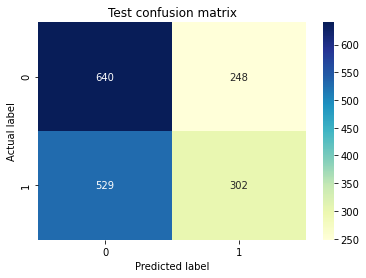

In [36]:
accuracy=accuracy_score(y_test,test_prediction)
print("Test accuracy_score",accuracy)
f1_test_score=f1_score(y_test,test_prediction)
print("Test F1_score",f1_test_score)
print("Test confusion matrix")
cnf_matrix2=confusion_matrix(y_test,test_prediction)
p = sns.heatmap(pd.DataFrame(cnf_matrix2), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Test confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

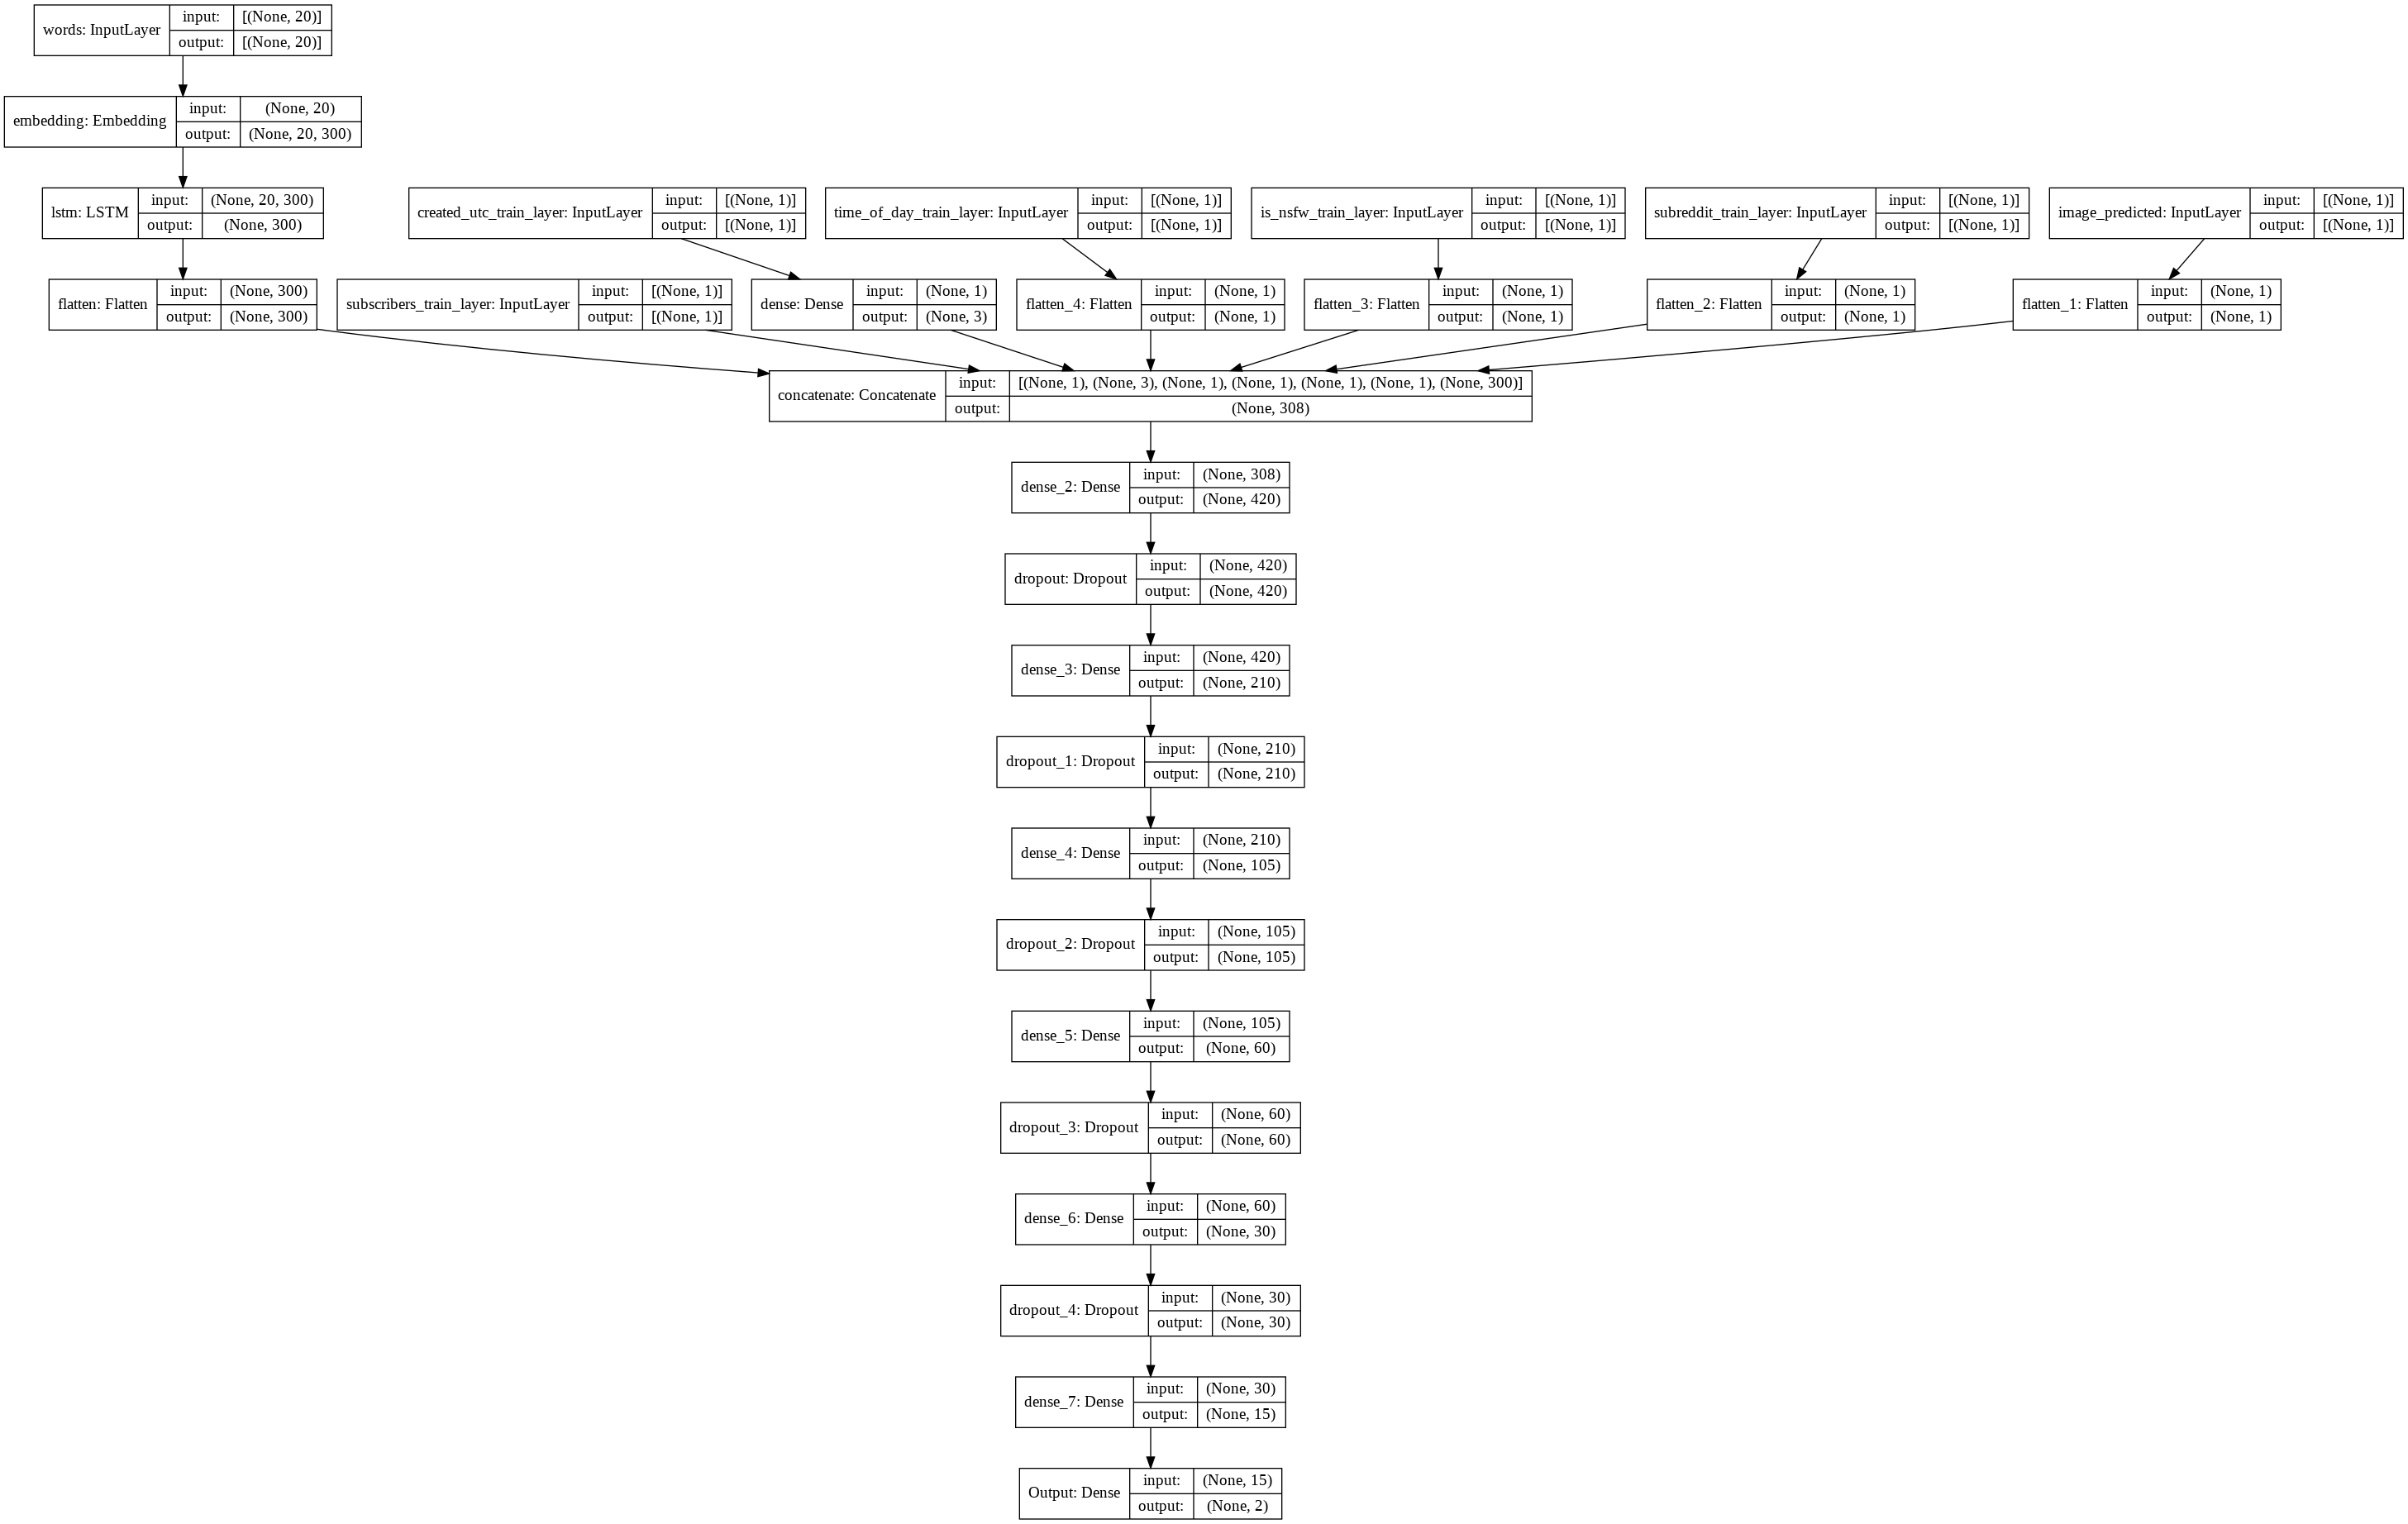

In [37]:
file = '/content/model_1.png'
tf.keras.utils.plot_model(model,to_file=file, show_shapes=True)